<h1>Given Task: Perform a Text Classification on consumer complaint dataset</h1> 
Dataset: (https://catalog.data.gov/dataset/consumer-complaint-database)

#### 1.Explanatory Data Analysis and Feature Engineering 

In [1]:
# Importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Loading the dataset
df = pd.read_csv(r"D:\complaints.csv")
print(df.head())


C:\Users\Muhilan\AppData\Local\Temp\ipykernel_11812\3342166241.py:2: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r"D:\complaints.csv")


  Date received                                            Product  \
0    2025-01-29  Credit reporting or other personal consumer re...   
1    2025-01-30  Credit reporting or other personal consumer re...   
2    2025-01-29  Payday loan, title loan, personal loan, or adv...   
3    2025-01-27  Credit reporting or other personal consumer re...   
4    2025-01-28  Credit reporting or other personal consumer re...   

        Sub-product                                              Issue  \
0  Credit reporting               Incorrect information on your report   
1  Credit reporting                        Improper use of your report   
2  Installment loan                       Problem when making payments   
3  Credit reporting  Problem with a company's investigation into an...   
4  Credit reporting                        Improper use of your report   

                                           Sub-issue  \
0                           Account status incorrect   
1      Reporting compa

##### Filtering the dataset

In [3]:
df = df[['Product', 'Consumer complaint narrative']]

#Dropping the missing complaints
df = df.dropna(subset=['Consumer complaint narrative'])

In [4]:
# Resetting index
df.reset_index(drop=True, inplace=True)

In [5]:
print(df['Product'].unique())


['Credit reporting or other personal consumer reports' 'Credit card'
 'Money transfer, virtual currency, or money service' 'Debt collection'
 'Student loan' 'Checking or savings account' 'Mortgage' 'Consumer Loan'
 'Vehicle loan or lease' 'Debt or credit management'
 'Payday loan, title loan, personal loan, or advance loan' 'Prepaid card'
 'Credit reporting, credit repair services, or other personal consumer reports'
 'Credit card or prepaid card' 'Payday loan, title loan, or personal loan'
 'Bank account or service' 'Credit reporting' 'Payday loan'
 'Money transfers' 'Other financial service' 'Virtual currency']


In [6]:
print( df.shape)

(2515449, 2)


In [7]:
# Filtering out the non-required products
product_mapping = {
    'Credit reporting or other personal consumer reports': 0,
    'Credit reporting, credit repair services, or other personal consumer reports': 0,
    'Credit reporting': 0,
    'Debt collection': 1,
    'Consumer Loan': 2,
    'Mortgage': 3
}

df['Product'] = df['Product'].str.strip()

df['label'] = df['Product'].map(product_mapping)

In [8]:
# removing the non-required products
df = df.dropna(subset=['label'])

print(df.shape)

(2034878, 3)


In [9]:
df.head()

,Product,Consumer complaint narrative,label
0,Credit reporting or other personal consumer re...,Subject : Complaint Regarding Inaccurate Late ...,0.0
1,Credit reporting or other personal consumer re...,Subject : Formal Complaint Against XXXX and Tr...,0.0
2,Credit reporting or other personal consumer re...,Subject : Follow-Up on Dispute Submitted XX/XX...,0.0
3,Credit reporting or other personal consumer re...,XX/XX/year> Subject : XXXX XXXX XXXX TransUnio...,0.0
4,Credit reporting or other personal consumer re...,XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX X...,0.0


##### Checking if dataset is balanced after filtering out

In [10]:
print(df['Product'].unique())


['Credit reporting or other personal consumer reports' 'Debt collection'
 'Mortgage' 'Consumer Loan'
 'Credit reporting, credit repair services, or other personal consumer reports'
 'Credit reporting']


In [11]:
# Drop rows that don't match the selected categories
df = df.dropna(subset=['label'])

print(df['label'].value_counts())

label
0.0    1595289
1.0     304468
3.0     125660
2.0       9461
Name: count, dtype: int64


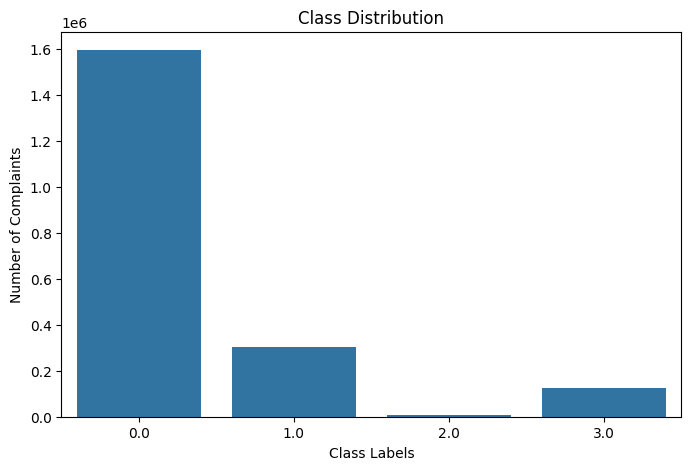

In [12]:
# Class Distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='label', data=df)
plt.title('Class Distribution')
plt.xlabel('Class Labels')
plt.ylabel('Number of Complaints')
plt.show()



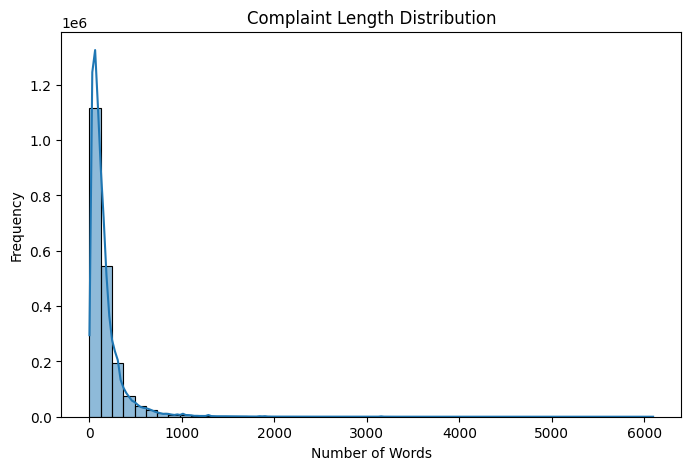

In [13]:
# Complaint Length Distribution
df['Complaint Length'] = df['Consumer complaint narrative'].apply(lambda x: len(x.split()))

plt.figure(figsize=(8, 5))
sns.histplot(df['Complaint Length'], bins=50, kde=True)
plt.title('Complaint Length Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

### 2.Text Pre-Processing  

In [3]:
#Removing stopwords and special characters, Lowering and lemmatizing the dataset 
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Muhilan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Muhilan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [15]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Text Cleaning Function
def clean_text(text):
    text = str(text).lower()                              
    text = re.sub(r'[^a-zA-Z]', ' ', text)                
    text = text.split()
    text = [word for word in text if word not in stop_words]  
    text = [lemmatizer.lemmatize(word) for word in text]      
    return ' '.join(text)

In [16]:
#Cleaning the dataset
df['Cleaned_Complaint'] = df['Consumer complaint narrative'].apply(clean_text)

print(df['Cleaned_Complaint'].head())

0    subject complaint regarding inaccurate late pa...
1    subject formal complaint xxxx transunion non c...
2    subject follow dispute submitted xx xx year re...
3    xx xx year subject xxxx xxxx xxxx transunion x...
4    xxxx xxxx xxxx xxxx xxxx xxxx xxxx xxxx xxxx x...
Name: Cleaned_Complaint, dtype: object


#### Vectorizing the data using TF-IDF vectorization

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000) 
X = tfidf.fit_transform(df['Cleaned_Complaint'])

y = df['label']
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)


Shape of X: (2034878, 5000)
Shape of y: (2034878,)


##### Balancing the dataset with the help of SMOTE

In [18]:
from sklearn.model_selection import train_test_split

# Splitting Dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Before SMOTE:")
print(y_train.value_counts())

Before SMOTE:
label
0.0    1276231
1.0     243574
3.0     100528
2.0       7569
Name: count, dtype: int64


In [21]:
# Balancing the dataset by undersampling majority classes
df_balanced = pd.concat([
    df[df['label'] == 0].sample(7569, random_state=42),
    df[df['label'] == 1].sample(7569, random_state=42),
    df[df['label'] == 2].sample(7569, random_state=42),
    df[df['label'] == 3].sample(7569, random_state=42)
], axis=0).reset_index(drop=True)

# Checking the new class distribution
print("Balanced Dataset Class Distribution:\n", df_balanced['label'].value_counts())


Balanced Dataset Class Distribution:
 label
0.0    7569
1.0    7569
2.0    7569
3.0    7569
Name: count, dtype: int64


In [28]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("\nAfter SMOTE:")
print(y_train_smote.value_counts())


After SMOTE:
label
0.0    1276231
1.0    1276231
3.0    1276231
2.0    1276231
Name: count, dtype: int64


In [53]:
import pandas as pd

# Convert the SMOTE-applied features to DataFrame
X_train_smote_df = pd.DataFrame(X_train_smote)

# Add the target labels as a new column
X_train_smote_df['target'] = y_train_smote.values

# Save the data to a CSV file
X_train_smote_df.to_csv("smote_applied_data.csv", index=False)

print("SMOTE-applied data saved successfully.")


SMOTE-applied data saved successfully.


## 3.Selection of Multi Classification model

#### For the given project, both Machine Learning and Deep Learning models could be considered. Machine learning models like Logistic Regression could be selected as a baseline model due to their simplicity, faster training time, and interpretability. On the other hand, Deep Learning models such as BiLSTM could be chosen. For better understanding lets try to compare both the models.(i.e,Logistic Regression and BiLSTM).

## 4.Comparison of model performance and 5.Model Evaluation 

### For model comnparison we will be trying with BiLSTM model because of its better understandability and Logistic Regression model because of its better interpretability.

BiLSTM outperforms Logistic Regression due to its ability to process sequential data bidirectionally, understand long-term dependencies, handle class imbalances, and leverage meaningful word embeddings—all of which contribute to higher accuracy and recall in complaint categorization.

Logistic Regression is a simple linear model that treats words independently and lacks sequential understanding.
BiLSTM processes text in both forward and backward directions, capturing long-range dependencies in complaints. This helps in understanding the context better, especially in cases where words at the beginning and end influence the category.

##### Implementation of Logistic Regression

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Vectorizing the balanced dataset
X = tfidf.transform(df_balanced['Cleaned_Complaint'])  # Reuse the same TF-IDF vectorizer
y = df_balanced['label']

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initializing and training the Logistic Regression model
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)

# Making Predictions
y_pred = lr_model.predict(X_test)

# Evaluation Metrics
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy Score: 0.868229854689564

Classification Report:
               precision    recall  f1-score   support

         0.0       0.84      0.87      0.85      1489
         1.0       0.83      0.81      0.82      1575
         2.0       0.87      0.85      0.86      1484
         3.0       0.94      0.95      0.94      1508

    accuracy                           0.87      6056
   macro avg       0.87      0.87      0.87      6056
weighted avg       0.87      0.87      0.87      6056



##### Implementation and evaluation of BiLSTM

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# BiLSTM Model
class BiLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.3):
        super(BiLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=2, bidirectional=True, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # 2 for bidirectional
        self.dropout = nn.Dropout(dropout)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        x = x.unsqueeze(1)  # Add sequence length dimension
        lstm_out, _ = self.lstm(x)
        out = self.dropout(lstm_out[:, -1, :])
        out = self.fc(out)
        return self.softmax(out)

# Parameters
input_dim = X_train.shape[1]  # TF-IDF features
hidden_dim = 128
output_dim = len(set(y_train))
batch_size = 256
epochs = 2
lr = 0.001


Using device: cuda


In [28]:
# Model Initialization
model = BiLSTM(input_dim, hidden_dim, output_dim).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Generator to convert sparse matrix to dense tensors in batches
class SparseDataset(torch.utils.data.IterableDataset):
    def __init__(self, X_sparse, y, batch_size):
        self.X_sparse = X_sparse
        self.y = y
        self.batch_size = batch_size
        self.indices = list(range(0, X_sparse.shape[0], batch_size))
        
    def __iter__(self):
        for i in self.indices:
            X_batch = torch.tensor(self.X_sparse[i:i+self.batch_size].toarray(), dtype=torch.float32)
            y_batch = torch.tensor(self.y[i:i+self.batch_size].values, dtype=torch.long)
            yield X_batch, y_batch

# Create Dataset and DataLoader
dataset = SparseDataset(X_train, y_train, batch_size)
dataloader = DataLoader(dataset, batch_size=None)

# Training Loop with Batches
print("Training BiLSTM model with Batches...")
model.train()
for epoch in range(epochs):
    total_loss = 0
    for X_batch, y_batch in dataloader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(dataset.indices)}")

# Evaluation
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for X_batch, y_batch in dataloader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        outputs = model(X_batch)
        predictions = outputs.argmax(dim=1).cpu().numpy()
        y_true.extend(y_batch.cpu().numpy())
        y_pred.extend(predictions)

print(classification_report(y_true, y_pred))


Training BiLSTM model with Batches...
Epoch 1/2, Loss: 0.9311545632387462
Epoch 2/2, Loss: 0.3622493383131529
              precision    recall  f1-score   support

           0       0.87      0.90      0.88      6080
           1       0.89      0.83      0.86      5994
           2       0.90      0.92      0.91      6085
           3       0.97      0.96      0.96      6061

    accuracy                           0.90     24220
   macro avg       0.90      0.90      0.90     24220
weighted avg       0.90      0.90      0.90     24220



### BiLSTM model performs better than Logistic Regression due to its higher accuracy and recall.



## 6.Prediction  

In [29]:
# Example Complaints
new_complaints = [
    "I am facing issues with my credit report.",
    "Debt collector is harassing me with frequent calls.",
    "I am unable to pay my mortgage loan.",
    "I applied for a consumer loan but got rejected without any reason."
]

# Preprocess the complaints (Apply the same cleaning function)
new_complaints_cleaned = [clean_text(text) for text in new_complaints]

# Vectorize the cleaned complaints using the same TF-IDF Vectorizer
X_new = tfidf.transform(new_complaints_cleaned)

# Convert to PyTorch Tensor
X_new_tensor = torch.tensor(X_new.toarray(), dtype=torch.float).to(device)

# Set the model to evaluation mode
model.eval()

# Perform Prediction
with torch.no_grad():
    predictions = model(X_new_tensor)
    predicted_classes = torch.argmax(predictions, axis=1).cpu().numpy()

# Mapping Labels back to Product Names
label_mapping = {
    0: 'Credit reporting or other personal consumer reports',
    1: 'Debt collection',
    2: 'Consumer Loan',
    3: 'Mortgage'
}

# Display Results
for text, pred in zip(new_complaints, predicted_classes):
    print(f"Complaint: {text}")
    print(f"Predicted Class: {label_mapping[pred]}")
    print()


Complaint: I am facing issues with my credit report.
Predicted Class: Credit reporting or other personal consumer reports

Complaint: Debt collector is harassing me with frequent calls.
Predicted Class: Debt collection

Complaint: I am unable to pay my mortgage loan.
Predicted Class: Mortgage

Complaint: I applied for a consumer loan but got rejected without any reason.
Predicted Class: Consumer Loan



# Areas of Improvement:

*   **Using better model**: The project could be more better if we had used BERT model. Due less computational power we werent able perform BERT model.
*   **Hyperparameter Tuning**: The project could be more better if we had tuned the model as well as increase the epoch count by applying early stop.
*   **Introducing interpretability**: Performing interpretability may help us to know which word contributes the most for classification.
*   **Using complete SMOTE applied data**: We had undersampled the dataset due to lack of computaional power, Using more data may help us to improve the model performance.
